In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj, sigmax, sigmaz, tensor, destroy, qeye, basis, fidelity
from scipy.optimize import minimize
from matplotlib.ticker import MaxNLocator
import qutip as qp

In [2]:
# Define parameters
omega_0 = 1  # cavity frequency (ω_0)
Omega = 1  # qubit frequency (Ω)
lambda_val = 0.2 # coupling strength (λ)
tru = 50  # Hilbert space dimension for cavity mode
tau = 0.02  # Fixed time step for evolution
steps=100
shots=1

In [3]:
# Cavity mode operator
a = tensor(destroy(tru), qeye(2))

# atom operators
sz = tensor(qeye(tru), sigmaz()) 
sx = tensor(qeye(tru), sigmax())  

# The Rabi model Hamiltonian
H1 = omega_0 * a.dag() * a  
H2 = (Omega / 2) * sz  
H3 = lambda_val * (a.dag() + a) * sx  
H = H1 + H2 + H3  

In [4]:
op=H

fidelities_origin = []
eigenvalues_1, _ = np.linalg.eig(H1)
eigenvalues_2, _ = np.linalg.eig(H2)
eigenvalues_3, _ = np.linalg.eig(H3)

c1 = max(eigenvalues_1)
c2 = max(eigenvalues_2)
c3 = max(eigenvalues_3)

k = c1 + c2 + c3
    
# Probabilities for random selection
p1 = c1 / k
p2 = c2 / k
p3 = c3 / k
ps=[p1,p2,p3]

# Normalized Hamiltonians
H1_norm = H1 / c1
H2_norm = H2 / c2
H3_norm = H3 / c3
Hs=[H1_norm,H2_norm,H3_norm]
    
    
#initial_state=tensor(basis(tru,5), basis(2, 0))
initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
rho = initial_state*initial_state.dag() 
exact_state=initial_state

for j in range(steps):

    exact_state = (-1j * H * tau).expm()*exact_state # evolution of exact statae
    rho_exact = exact_state*exact_state.dag()
    
    # evolution of random state in channel formula 
    rhos=[]
    for i in range(3):
        rhos.append(ps[i]*(-1j * Hs[i] * tau*k).expm() * rho * (1j * Hs[i] * tau*k).expm())
    rho=sum(rhos)
    
    # Calculate fidelity
    fidelity_origin = fidelity(rho,rho_exact)
    fidelities_origin.append(fidelity_origin)

In [5]:
op=H

fidelities_ew = []
c1 = 0.1
c2 = 0.1
c3 = 0.1

k = c1 + c2 + c3
    
# Probabilities for random selection
p1 = c1 / k
p2 = c2 / k
p3 = c3 / k
ps=[p1,p2,p3]

# Normalized Hamiltonians
H1_norm = H1 / c1
H2_norm = H2 / c2
H3_norm = H3 / c3
Hs=[H1_norm,H2_norm,H3_norm]
    
    
#initial_state=tensor(basis(tru,5), basis(2, 0))
initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
rho = initial_state*initial_state.dag() 
exact_state=initial_state

for j in range(steps):

    exact_state = (-1j * H * tau).expm()*exact_state # evolution of exact statae
    rho_exact = exact_state*exact_state.dag()
    
    # evolution of random state in channel formula 
    rhos=[]
    for i in range(3):
        rhos.append(ps[i]*(-1j * Hs[i] * tau*k).expm() * rho * (1j * Hs[i] * tau*k).expm())
    rho=sum(rhos)
    
    # Calculate fidelity
    fidelity_ew = fidelity(rho,rho_exact)
    fidelities_ew.append(fidelity_ew)

In [6]:
terms=[]
terms.append(H1)
terms.append(H2)
terms.append(H3)

In [7]:
def D_ij(H_i, H_j, rho):
    a = 1j * (H_j * rho - rho * H_j)
    b = 1j * (H_i * a - a * H_i)
    return b

In [8]:
dt = 0.001

In [9]:
def D(H, rho, error_list):
    T1 = qp.expect(H,rho) + error_list[0]
    T2 = qp.expect(H * H,rho) + error_list[1]
    T3 = qp.expect(H * H * H,rho) + error_list[2]
    T4 = qp.expect(H * H * H * H,rho) + error_list[3]
    result = np.sqrt(abs(6*T2**2 - 8*T1*T3 + 2*T4))
    return result

In [10]:
p1_list=[]
p2_list=[]
p3_list=[]

In [11]:
def Fidelity(steps, tau, shots):
    
    Fidelity_list = []
    
    initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
    rho_initial = initial_state*initial_state.dag() 
    exact_state=initial_state
    
    rho_steps_list = steps * [0]
    for i in range(shots):
        print(i)
        rho = rho_initial
        for j in range(steps):
            a = [0] * 4
            b = [0] * 4
            c = [0] * 4
            for k in range(4):
                a[k] = np.random.normal(loc=0, scale=0)
                b[k] = np.random.normal(loc=0, scale=0)
                c[k] = np.random.normal(loc=0, scale=0)
            
            D11 = D(terms[0], rho, a)
            D22 = D(terms[1], rho, b)
            D33 = D(terms[2], rho, c)
            
            Dsum=np.sqrt(D11)+np.sqrt(D22)+np.sqrt(D33)
            p1=np.sqrt(D11)/Dsum
            p2=np.sqrt(D22)/Dsum
            p3=np.sqrt(D33)/Dsum
            ps = [p1,p2,p3]
            
            p1_list.append(p1)
            p2_list.append(p2)
            p3_list.append(p3)
            
            rand= np.random.rand()
            if rand < ps[0]:
                rho = (-1j * H1 * tau/p1).expm() * rho * (1j * H1 * tau/p1).expm()
            elif rand < ps[0] + ps[1]:
                rho = (-1j * H2 * tau/p2).expm() * rho * (1j * H2 * tau/p2).expm()
            else:
                rho = (-1j * H3 * tau/p3).expm() * rho * (1j * H3 * tau/p3).expm()
            rho_steps_list[j] += rho / shots

    for i in range(steps):
        
        rho_exact = exact_state*exact_state.dag()
        
        Fidelity = fidelity(rho_steps_list[i],rho_exact)
        Fidelity_list.append(Fidelity)
        
        exact_state = (-1j * H * tau).expm()*exact_state
    
    return Fidelity_list

In [12]:
Fidelity_list = Fidelity(steps, tau, shots)

0


In [13]:
print(Fidelity_list)

[0.9992002839374384, 0.9994837809164239, 0.9994227438249785, 0.9990197853896103, 0.99827175397103, 0.9971801945511104, 0.9957442891916346, 0.9939678219749446, 0.9973186651254301, 0.9958770455933016, 0.9940527237303176, 0.9971419360427511, 0.995681818498544, 0.9938035422820226, 0.9965975697416042, 0.9950941682912365, 0.9931377968429238, 0.9956037358564213, 0.9940205044913375, 0.9919525168851331, 0.9940514211477105, 0.9923516729685977, 0.9901348452497268, 0.9873995090111353, 0.9930755227363478, 0.9965798162089022, 0.9946595162796125, 0.9973835573112837, 0.9977765794711276, 0.9990507124558676, 0.9991769223408598, 0.9987621654949119, 0.998830031936214, 0.9960884543515361, 0.9966022836703722, 0.9971102426969894, 0.9980468668786778, 0.9984481308779664, 0.9983048977511751, 0.9976072374302377, 0.9956690713911427, 0.9952599069133045, 0.994302927560748, 0.990872496579335, 0.9902268276792237, 0.9890462316782107, 0.9943281623513981, 0.9935072454798173, 0.9921107233938534, 0.9901286990968973, 0.987

In [14]:
print(fidelities_origin)

[0.998779053821648, 0.9975570653354111, 0.9963305914298246, 0.9950984397074819, 0.9938582568455668, 0.9926065553044557, 0.991340124201501, 0.9900556637606803, 0.9887498363779355, 0.9874226211814031, 0.9860679783695325, 0.9846859447113957, 0.9832734598910257, 0.9818296133315528, 0.9803510315337872, 0.9788356592335116, 0.97728412954402, 0.975694876969293, 0.9740619781680636, 0.9723898241539484, 0.9706742244663129, 0.9689161450540343, 0.9671123895132747, 0.9652657947723147, 0.9633724637021736, 0.9614355701831173, 0.9594508956994223, 0.9574199821181736, 0.9553456031635152, 0.9532242939816586, 0.9510576875475321, 0.9488439472275715, 0.9465857932783831, 0.9442827128444004, 0.941936302383316, 0.9395456195605126, 0.9371129089600453, 0.9346363239614366, 0.9321191491665939, 0.9295593428355332, 0.9269597881706616, 0.9243213993271918, 0.9216463035295642, 0.9189336001636941, 0.916183224883971, 0.913398771408145, 0.9105811932265273, 0.9077283680873427, 0.904843436034369, 0.9019286742805714, 0.898982

In [15]:
print(fidelities_ew)

[0.9989767662658223, 0.997953818773978, 0.9969316223782894, 0.9959121167534768, 0.9948920601360823, 0.99387606901408, 0.9928590423988025, 0.9918435776597218, 0.9908287737334992, 0.9898145619106562, 0.9888013231054925, 0.9877845949191308, 0.9867704330763915, 0.9857543964778194, 0.9847401963734023, 0.9837207898361364, 0.9827012665270677, 0.9816809052217201, 0.9806589126423221, 0.9796344313646475, 0.9786095586955239, 0.977580066322425, 0.9765485759605557, 0.9755161865318085, 0.9744819463747332, 0.9734433660779008, 0.9724023324833302, 0.9713570155814016, 0.9703109891601663, 0.9692606440102407, 0.9682075521397845, 0.9671517398912022, 0.9660917536959411, 0.9650291229753721, 0.9639627252943289, 0.9628938948075609, 0.9618200475497289, 0.9607443078629136, 0.9596631273674994, 0.958580469998842, 0.9574933764729432, 0.9564020924178945, 0.9553077775470399, 0.9542114305881293, 0.9531117832166032, 0.9520067667573985, 0.9508986960213313, 0.9497864398660903, 0.9486710182246849, 0.9475544889232145, 0.94

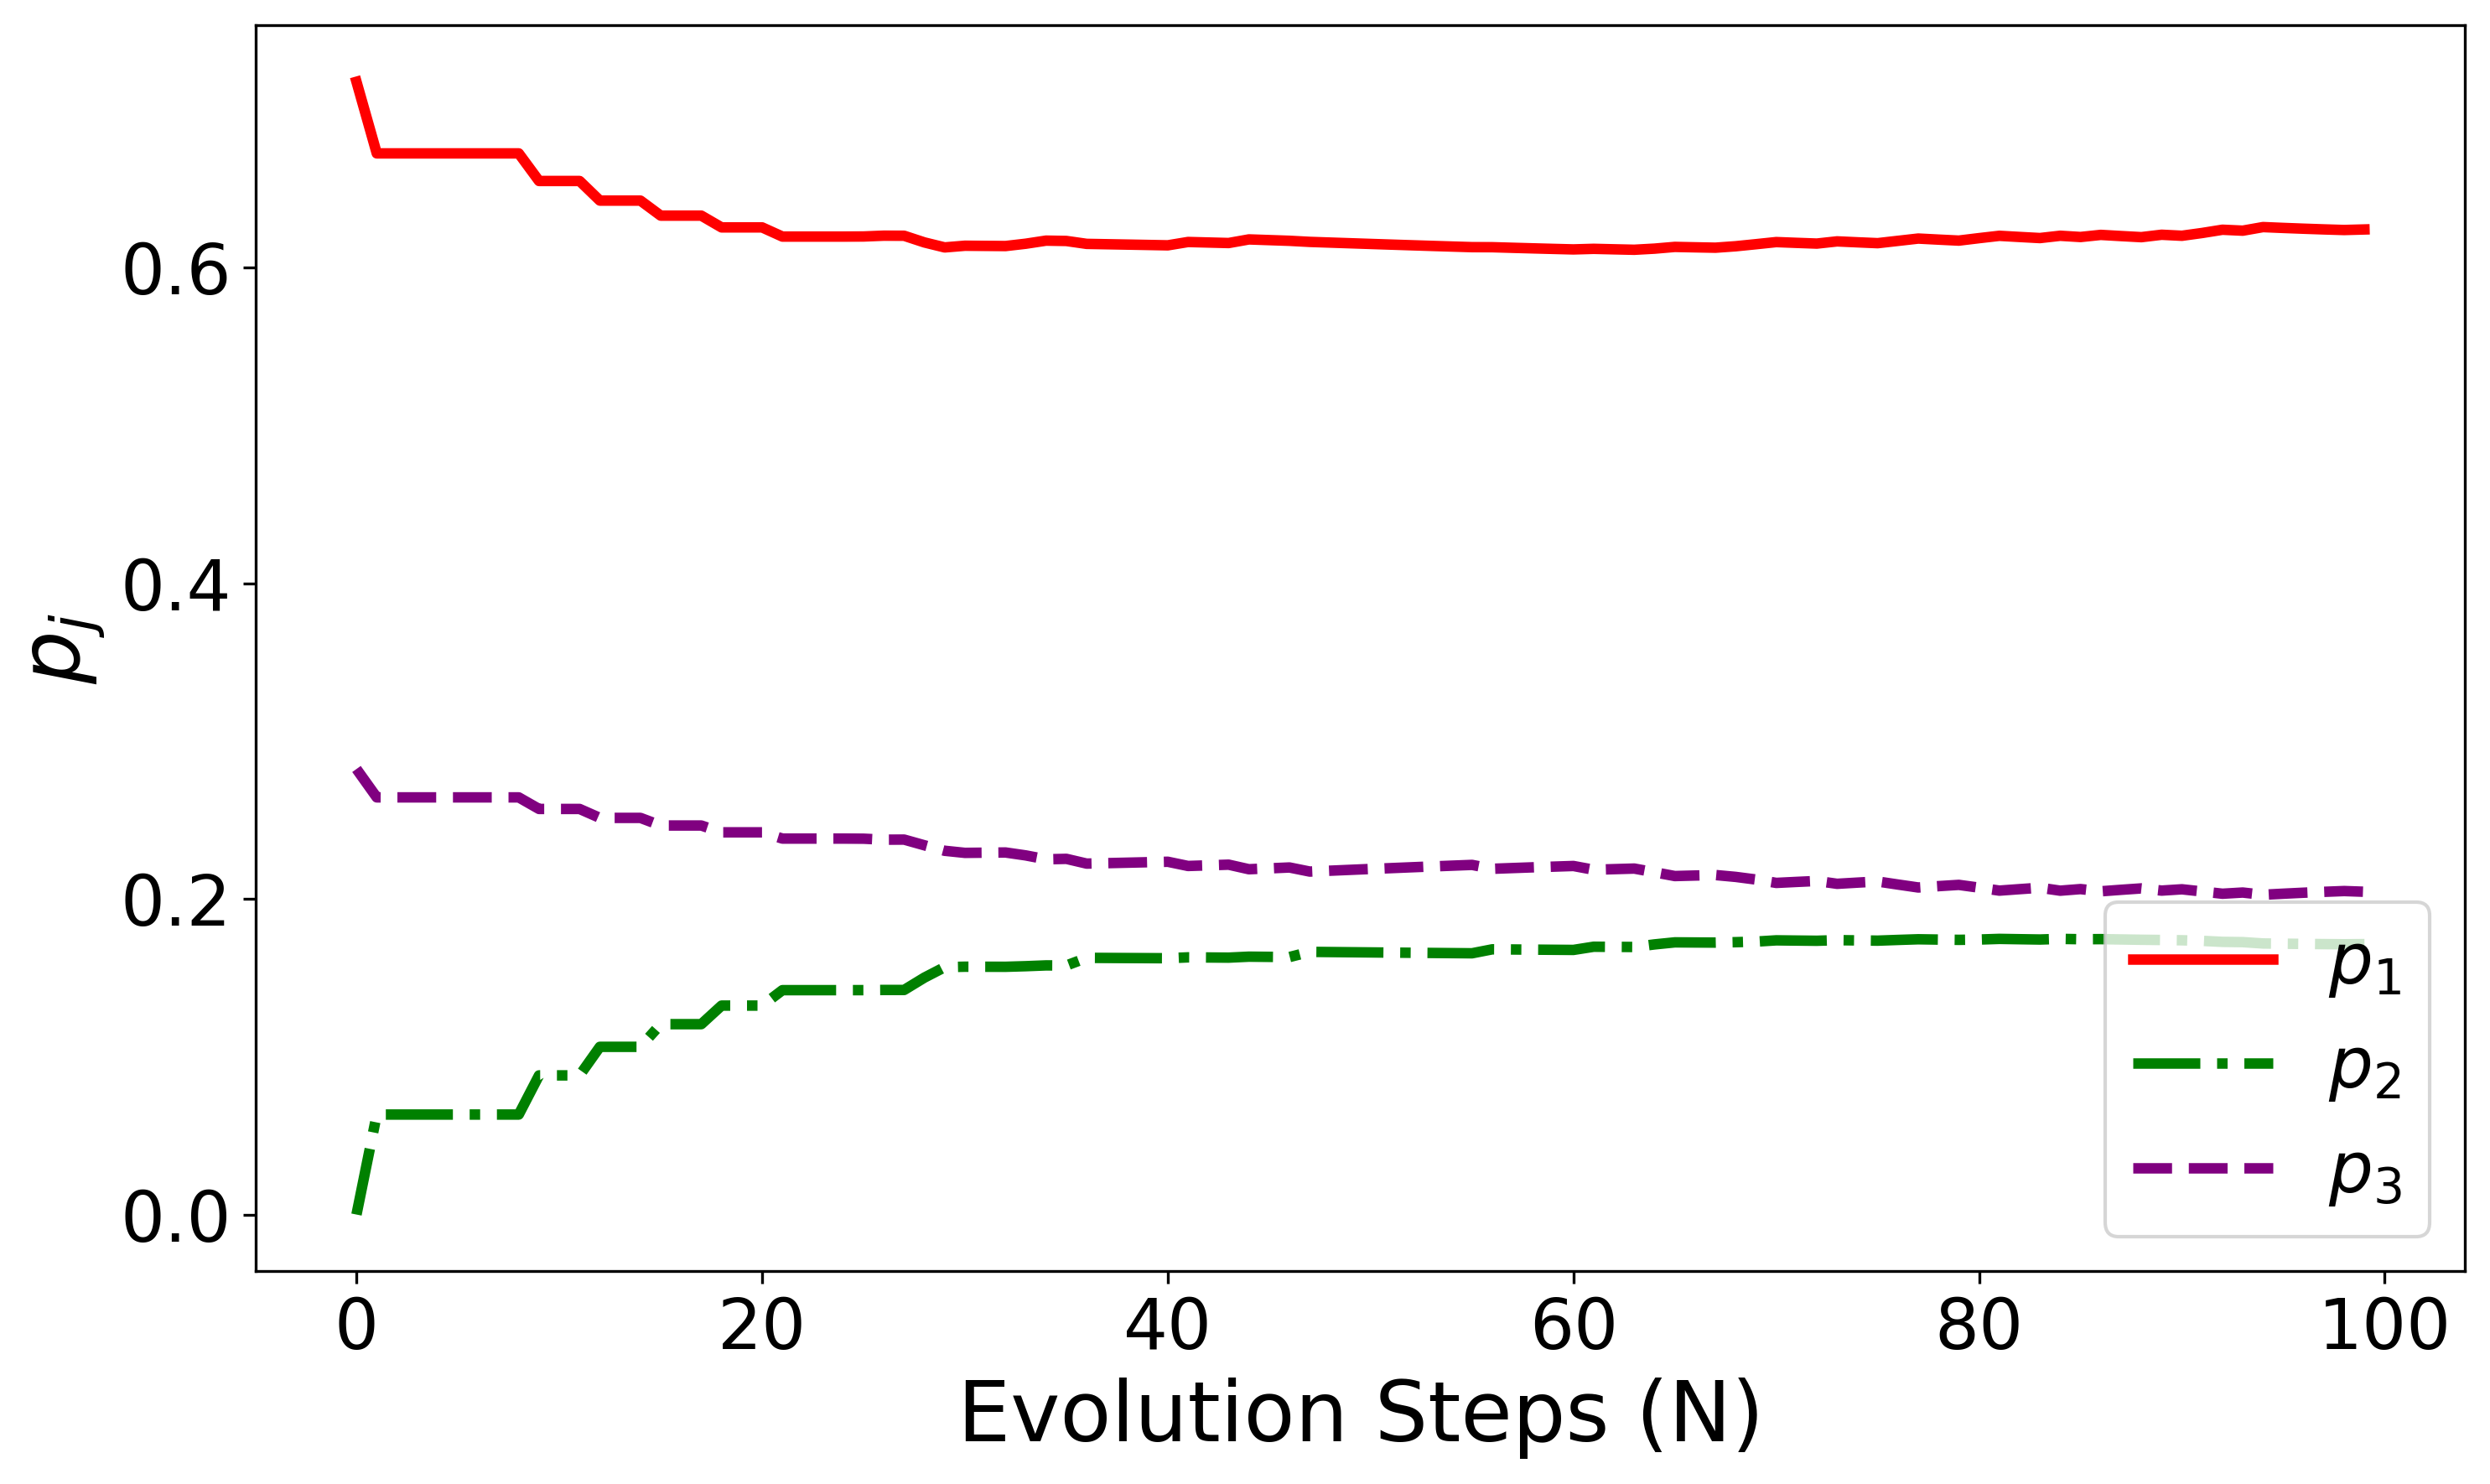

In [16]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(range(steps), p1_list, label=r"${p}_{1}$", color='red', linestyle='-', linewidth=3)
plt.plot(range(steps), p2_list, label=r"${p}_{2}$", color='green', linestyle='-.', linewidth=3)
plt.plot(range(steps), p3_list, label=r"${p}_{3}$", color='purple', linestyle='--', linewidth=3)
plt.xlabel("Evolution Steps (N)", fontsize=24)
plt.ylabel(r"$p_{j}$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc='lower right')

ax = plt.gca()  # 获取当前坐标轴
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
plt.show()

In [17]:
range(steps)

range(0, 100)

In [18]:
p1_list

[0.7176774994016504,
 0.6723160516522034,
 0.6723160516534067,
 0.6723160516545926,
 0.672316051655755,
 0.6723160516568729,
 0.6723160516579924,
 0.6723160516590928,
 0.6723160516601737,
 0.6548348194912509,
 0.654834819491003,
 0.6548348194906694,
 0.6424034980921538,
 0.6424034980922455,
 0.6424034980923568,
 0.6328789632191127,
 0.6328789632191566,
 0.6328789632192018,
 0.6254244682962175,
 0.6254244682962626,
 0.6254244682963102,
 0.6196093007842978,
 0.6196093007844032,
 0.6196093007845036,
 0.6196093007846037,
 0.6196693509385457,
 0.6201802504453803,
 0.6201293495859387,
 0.6159104723885188,
 0.6127466726188301,
 0.6138058624415164,
 0.6137088949092888,
 0.6136105636856091,
 0.6150927899105676,
 0.6170466291675653,
 0.6168244507210404,
 0.6149902637820168,
 0.6147657406484577,
 0.614536839219857,
 0.614304504735973,
 0.6140696868420246,
 0.616184213086024,
 0.6158554295135747,
 0.6155240568909154,
 0.6178147521489178,
 0.6173768595823717,
 0.6169374073348752,
 0.616246783336402

In [19]:
p2_list

[2.064919541552375e-05,
 0.06337190359053023,
 0.06337190358901579,
 0.06337190358753007,
 0.06337190358607427,
 0.06337190358464478,
 0.06337190358324431,
 0.06337190358186999,
 0.06337190358052333,
 0.08818499959121309,
 0.08818499959129879,
 0.08818499959136472,
 0.10627750562850584,
 0.10627750562849715,
 0.1062775056284934,
 0.12063121610378348,
 0.12063121610378745,
 0.12063121610379163,
 0.13240251150113158,
 0.13240251150114107,
 0.1324025115011512,
 0.142177762404109,
 0.14217776240406974,
 0.14217776240403204,
 0.14217776240399801,
 0.14219154172671855,
 0.14230877455166088,
 0.1422970946586636,
 0.1501262930399931,
 0.15676492538861742,
 0.15703590819602561,
 0.1570111000515933,
 0.15698594302074817,
 0.1573651553347408,
 0.15786502498574298,
 0.1578081829184599,
 0.1626470389301172,
 0.16258765909112555,
 0.16252712132042996,
 0.16246567560645603,
 0.16240357310274575,
 0.16296280379723646,
 0.1628758501043782,
 0.1627882116830367,
 0.16339403395818564,
 0.16327822410961956

In [20]:
p3_list

[0.2823018514029341,
 0.26431204475726633,
 0.2643120447575776,
 0.26431204475787734,
 0.26431204475817066,
 0.26431204475848225,
 0.26431204475876335,
 0.26431204475903725,
 0.2643120447593031,
 0.256980180917536,
 0.25698018091769825,
 0.256980180917966,
 0.2513189962793404,
 0.25131899627925736,
 0.25131899627914994,
 0.24648982067710382,
 0.2464898206770559,
 0.24648982067700664,
 0.24217302020265094,
 0.24217302020259632,
 0.24217302020253864,
 0.23821293681159317,
 0.23821293681152714,
 0.23821293681146438,
 0.23821293681139827,
 0.23813910733473584,
 0.2375109750029588,
 0.23757355575539782,
 0.23396323457148813,
 0.23048840199255244,
 0.22915822936245786,
 0.22928000503911786,
 0.2294034932936428,
 0.2275420547546915,
 0.22508834584669168,
 0.22536736636049964,
 0.22236269728786603,
 0.2226466002604168,
 0.22293603945971308,
 0.22322981965757108,
 0.2235267400552297,
 0.22085298311673965,
 0.22126872038204712,
 0.22168773142604783,
 0.2187912138928966,
 0.21934491630800876,
 0.